The project is based on [Hetionet](https://het.io/about/)
which is a heterogeneous biomedical knowledge graph. It encodes relationships uncovered by millions of studies conducted over the last half-century into a single resource.


the json data can be found [here](https://github.com/hetio/hetionet/tree/master/hetnet/json)

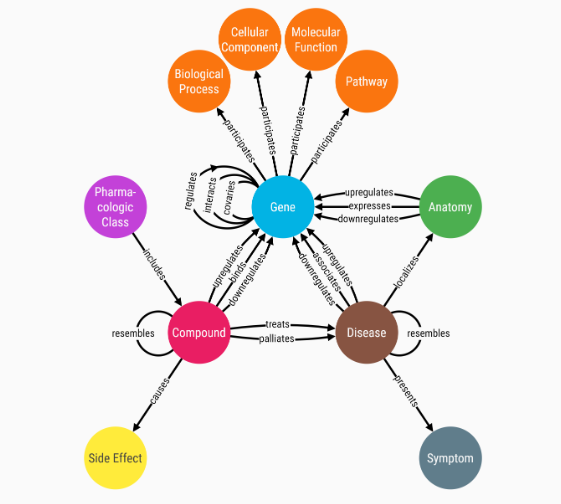

I'm only using Disease, Gene and Compound meta nodes and the relationships between them.

The target is to predict new edges between Diseases and Genes (Disease-Gene associations)

and between those two node types (Disease, Gene) I'm only using the association edge type to make sure there is no information leak from other edge types

I used two different approaches for encoding the graph

*   building a normal homogeneous GNN and transform it with to_hetero function (basically makes a layer for every edge_type) like this [tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html) 
*   Used RGCN module which is based on this [paper](https://arxiv.org/abs/1703.06103)



[colab link](https://colab.research.google.com/drive/1fhF8h7xJoYaKr4ZPLrToN0e5sDhiiXKX?usp=sharing)

In [ ]:
"""
those versions were guaranteed to work on colab on cpu(which is not slow in this case) 
colab might crash if I tried to use them on gpu (but locally on my machine latest versions work fine)

"""
!pip install torch==1.10.0+cu111  -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cpu.html

In [ ]:
#this just loads the the zip file containing torch tensors I processed for the model
!gdown  1AkInoTO1SNlJnKEyYi7SpiBxaS2ecc4q 

Downloading...
From: https://drive.google.com/uc?id=1AkInoTO1SNlJnKEyYi7SpiBxaS2ecc4q
To: /content/torchHetnetData.zip
100% 3.18M/3.18M [00:00<00:00, 225MB/s]


In [ ]:
!unzip  torchHetnetData.zip

In [ ]:
from torch_geometric.utils import (
    add_self_loops,
    negative_sampling,
    remove_self_loops ,
)
import torch.nn.functional as F
from sklearn.metrics import accuracy_score,roc_auc_score,average_precision_score
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings("ignore")
import time


import numpy as np
import scipy.sparse as sp
from torch import nn
import pandas as pd
# import networkx as nx
from typing import List , Dict,Tuple
from torch_geometric.nn import SAGEConv, to_hetero
import torch

import matplotlib.pyplot as plt
import torch_geometric.nn as  gnn
from torch_geometric.data  import Data
import pandas as pd
from sklearn.preprocessing import LabelEncoder

if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("gpu up")
else:  
  dev = "cpu"  
device = torch.device(dev)


In [ ]:
"""
this cell transforms the json graph into torch tensors compatible with HeteroData Object
"""
# !wget "https://media.githubusercontent.com/media/hetio/hetionet/master/hetnet/json/hetionet-v1.0.json.bz2"
# !bzip2 -dk /content/hetionet-v1.0.json.bz2

# import json
# with open("/content/hetionet-v1.0.json") as f: 
#   hetnet =  json.load(f)

# nodes = pd.DataFrame(hetnet["nodes"])


# nodeTypeEncoder = {}
# for t in nodes.kind.unique():
#   tNodes = nodes[nodes.kind == t].reset_index()
#   enc = LabelEncoder()
#   enc.fit(tNodes.identifier)
#   nodeTypeEncoder[t] = enc
  
# graphDict = {}

# for tup in meta_graph["metaedge_tuples"]:
#   # edgeKey = f'{meta_graph["kind_to_abbrev"][tup[0]]}_{meta_graph["kind_to_abbrev"][tup[2]]}_{meta_graph["kind_to_abbrev"][tup[1]]}'
#   edgeKey = f'{tup[0]}_{tup[2]}_{tup[1]}'
#   revEdgeKey = f'{tup[1]}_{tup[2]}_{tup[0]}'
#   graphDict[edgeKey] = []
#   if tup[-1] == "both":
#      graphDict[revEdgeKey] = []


# for edge in hetnet["edges"]:
#   edgeKey = f'{edge["source_id"][0]}_{edge["kind"]}_{edge["target_id"][0]}'
#   # src = nodeTypeEncoder[edge["source_id"][0]].transform([edge["source_id"][1]])[0]
#   src = list(nodeTypeEncoder[edge["source_id"][0]].classes_).index(edge["source_id"][1])
#   revEdgeKey = f'{edge["target_id"][0]}_{edge["kind"]}_{edge["source_id"][0]}'
#   # print(edge)
#   trg = list(nodeTypeEncoder[edge["target_id"][0]].classes_).index(edge["target_id"][1])
#   graphDict[edgeKey].append([src,trg])
#   if edge["direction"] == 'both':
#     graphDict[revEdgeKey].append([trg,src])


# import numpy as np
# for k,v  in graphDict.items():
#   np.save("./hetnetData/"+k+".npy",np.array(v))

In [ ]:
from torch_geometric.data import HeteroData
import numpy as np
import os 
import torch


data = HeteroData()
path = "./torchHetnetData"
edge_types = []
for f in os.listdir(path):
  # print(f)
  name = f[:-3].split("_") 
  if len(name) == 1:
    data[name[0]].x = torch.load(os.path.join(path,f))
    print(name[0] , len(data[name[0]].x))
    continue
  if name[0] not in ["Gene","Compound","Disease"]: continue
  if name[2] not in ["Gene","Compound","Disease"]: continue
  # I removed any relations ships between disease and genes that are not the target edge
  #  
  if name[0] == "Gene" and name[2] == "Disease":
      if name[1] != "associates": continue 
  if name[0] == "Disease" and name[2] == "Gene":
      if name[1] != "associates": continue 
  e =  torch.load(os.path.join(path,f))
  if len(e[0]) <= 1000 : continue # disregard any edge type with less than 1000 instances 
  edge_types.append(name[1])
  data[name[0],name[1],name[2]].edge_index = e

from torch_geometric.transforms import RandomLinkSplit


transform = RandomLinkSplit(is_undirected=False,add_negative_train_samples=True,disjoint_train_ratio=0.35,edge_types=[("Disease","associates","Gene")],rev_edge_types=[("Gene","associates","Disease")])

train,valid,test = transform(data) 


Gene 20945
Compound 1552
Disease 137


In [ ]:
print(  
  len(train["Disease","associates","Gene"].edge_index[0])+ # train visible message passing edges 
  len(train["Disease","associates","Gene"].edge_label) /2  + # train positive supervision edges 
  len(valid["Disease","associates","Gene"].edge_label) /2 +  # validation positive evaluation edges
  len(test["Disease","associates","Gene"].edge_label) /2  )  # test positive evaluation edges
print(len(data["Disease","associates","Gene"].edge_index[0]) )  # all existing target edges in the graph

12623.0
12623


In [ ]:
data.edge_types

[('Compound', 'upregulates', 'Gene'),
 ('Gene', 'associates', 'Disease'),
 ('Gene', 'downregulates', 'Compound'),
 ('Disease', 'resembles', 'Disease'),
 ('Compound', 'resembles', 'Compound'),
 ('Gene', 'regulates', 'Gene'),
 ('Compound', 'downregulates', 'Gene'),
 ('Gene', 'binds', 'Compound'),
 ('Gene', 'interacts', 'Gene'),
 ('Compound', 'binds', 'Gene'),
 ('Disease', 'associates', 'Gene'),
 ('Gene', 'covaries', 'Gene'),
 ('Gene', 'upregulates', 'Compound')]

In [ ]:

"""
the GAE-like model follows the one here on this tutorial 
"""
class Encoder(nn.Module):
  """
  basic gnn with two layers to get representations for every node  
  """
  def __init__(self,node_dim=64):
    super(Encoder,self).__init__()   
    self.gconv1  =  gnn.SAGEConv((-1,-1),  node_dim)
    self.gconv2  = gnn.SAGEConv((-1,-1), node_dim)

  def forward(self,x,edge_index):
    h = self.gconv1(x,edge_index).relu()
    h = self.gconv2(h,edge_index)
    return h


EPS = 1e-15

class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        z = torch.cat([z_dict['Disease'][edge_label_index[0]], z_dict['Gene'][edge_label_index[1]]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z).sigmoid()
        return z.view(-1)


class MyGAE(nn.Module):

  def __init__(self,encoder,decoder,data:HeteroData,node_types:List[Tuple],node_dim:int):
    super(MyGAE,self).__init__()
    self.node_types = {}
    for n in node_types:
      self.node_types[n[0]]  = nn.Embedding(n[1],node_dim) # this part is redundant(we can use embeddings from torch geometric directly)
      self.node_types[n[0]].to(device)
    self.hetero_encoder =to_hetero(encoder,data.metadata())
    self.decoder = decoder

  def encode(self,nodes, edges):
    xVectors= {}
    for i in self.node_types.keys():
      xVectors[i] = self.node_types[i](nodes[i])
    return self.hetero_encoder(xVectors,edges)
    
  def decode(self,h,edge_label_index):
    
    return self.decoder(h,edge_label_index)

  def recon_loss(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.
        """

        pos_loss = -torch.log(
            self.decode(z, pos_edge_index) + EPS).mean()

        # Do not include self-loops in negative samples
        # pos_edge_index, _ = remove_self_loops(pos_edge_index)
        # pos_edge_index, _ = add_self_loops(pos_edge_index)
        neg_edge_index, _ = remove_self_loops(neg_edge_index)
        
        neg_loss = -torch.log(1 -
                              self.decode(z, neg_edge_index) +
                              EPS).mean()

        return pos_loss + neg_loss

  def test(self,z, edge_index, y ):
    r"""Given latent variables :obj:`z`, edges
    computes area under the ROC curve (AUC) , average precision (AP)
    and (Acc) accuracy scores  .
    Args:
        z (Tensor): The latent space :math:`\mathbf{Z}`.
        edge_index (LongTensor):   edges
        y  (Tensor):labels
    """
    pred =  self.decode(z, edge_index,)

    y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

    return roc_auc_score(y, pred), precision_score(y, pred>=0.5),accuracy_score(y,pred>0.5)
node_types = [("Compound",1552),("Gene",20945),("Disease",137)]

myGAE = MyGAE(Encoder(),EdgeDecoder(64),data,node_types,node_dim=64)
myGAE.to(device)
train = train.to(device)
with torch.no_grad():
    myGAE.encode(train.x_dict, train.edge_index_dict)


optimizer = torch.optim.Adam(myGAE.parameters(), lr=0.01, weight_decay=0.0005)

Proxy(getattr_1)


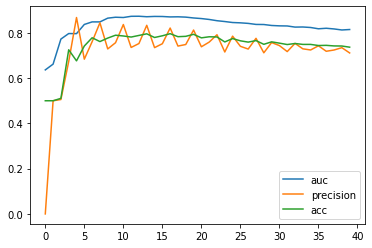

In [ ]:
validationMetrics = []
for i in range(40):
    myGAE.train()
    optimizer.zero_grad()
    # pred = myGAE(train.x_dict, train.edge_index_dict,
    #              train['Gene', "associates",'Disease'].edge_label_index)
    target = train['Disease',"associates", 'Gene'].edge_label
    label_edge_index = train['Disease',"associates", 'Gene'].edge_label_index
    h = myGAE.encode(train.x_dict,train.edge_index_dict)
    loss  = myGAE.recon_loss(h,label_edge_index[:,target==1],label_edge_index[:,target==0])
    loss.backward()
    optimizer.step()
    auc, p ,acc= myGAE.test(h, train['Disease',"associates", 'Gene'].edge_label_index,train['Disease',"associates", 'Gene'].edge_label)
    # print(i,"train", np.array([auc, p , acc]).round(3),end=' ')
    
    with torch.no_grad():
      myGAE.eval()
      test.to(device)
      z = myGAE.encode(test.x_dict,test.edge_index_dict)
      auc, p ,acc= myGAE.test(z, test['Disease',"associates", 'Gene'].edge_label_index,test['Disease',"associates", 'Gene'].edge_label)
      # auc, p = myGAE.test(z, valid.edge_label_index[:,valid.edge_label==1],valid.edge_label_index[:,valid.edge_label==0])
      # print("valid",np.array([auc, p , acc]).round(3))
      validationMetrics.append([auc, p , acc])

plt.plot(np.arange(len(validationMetrics)),np.array(validationMetrics)[:,0],label='auc')
plt.plot(np.arange(len(validationMetrics)),np.array(validationMetrics)[:,1],label='precision')
plt.plot(np.arange(len(validationMetrics)),np.array(validationMetrics)[:,2],label='acc')
plt.legend()
plt.show()

In [ ]:
from torch_geometric.data import Data
from typing import Tuple,List

"""
RGCN model requires a homogeneous "typed" graph
with a  tensor for edge types   
this function is the same as applying .to_homogeneous on a HeteroData object
but it's useful if I need to transform each node type a certain way 

"""

def  convert_hetero_object_to_RGCN(heteroData:HeteroData,edge_types:List[Tuple[str]]):
    dataRGCN = Data()
    datax  =  torch.arange(len(heteroData["Disease"].x) +len(heteroData["Gene"].x) + len(heteroData["Compound"].x))
    data_edge_index = torch.tensor([]).reshape(2,0)
    data_edge_types = torch.tensor([])
    # edge_types = []   
    for _, (key,v) in enumerate(heteroData.edge_index_dict.copy().items()):
        ourV = torch.tensor(v.cpu().numpy())
        if key[0] == "Compound":
            ourV[0,:] = ourV[0]+len(heteroData["Disease"].x) + len(heteroData["Gene"].x) 
        if key[0] == "Gene":
            ourV[0,:] = ourV[0]+len(heteroData["Disease"].x)
        
        if key[1] == "Compound":
            ourV[1,:] = ourV[1]+len(heteroData["Disease"].x) + len(heteroData["Gene"].x)
        if key[1] == "Gene":
            ourV[1,:] = ourV[1]+len(heteroData["Disease"].x)
        data_edge_index = torch.cat([data_edge_index,ourV],dim = -1)
        data_edge_types = torch.cat([data_edge_types,torch.zeros(len(ourV[0])) + edge_types.index(key)])
    dataRGCN.edge_index = data_edge_index
    dataRGCN.x = datax
    edge_label_index =torch.tensor( heteroData["Disease","associates","Gene"].edge_label_index.cpu().numpy())
    edge_label_index[1,:] += len(heteroData["Disease"].x)  
    edge_label = torch.tensor(heteroData["Disease","associates","Gene"].edge_label.cpu().numpy())
    target_label_type = torch.zeros(len(edge_label)) +data.edge_types.index(("Disease","associates","Gene"))
    dataRGCN.edge_label_index = edge_label_index
    dataRGCN.edge_label = edge_label
    dataRGCN.edge_type = data_edge_types
    dataRGCN.label_edge_type = target_label_type
    return  dataRGCN



rgcn_valid = convert_hetero_object_to_RGCN(valid,data.edge_types)
rgcn_train = convert_hetero_object_to_RGCN(train,data.edge_types)
rgcn_test = convert_hetero_object_to_RGCN(test,data.edge_types)

In [ ]:
rgcn_train

Data(edge_index=[2, 811786], x=[22634], edge_label_index=[2, 6184], edge_label=[6184], edge_type=[811786], label_edge_type=[6184])

In [ ]:
from torch import nn
class RGCNEncoder(nn.Module):

  def __init__(self,num_nodes,num_relations,node_dim=32):
    super(RGCNEncoder,self).__init__()   
    self.gconv1 = gnn.RGCNConv(node_dim, node_dim, num_relations,num_blocks=16)
    self.gconv2 = gnn.RGCNConv(node_dim, node_dim, num_relations,num_blocks=16)
  def forward(self,x,edge_index:torch.Tensor,edge_type:torch.Tensor):
    h = self.gconv1(x,edge_index,edge_type).relu()
    # print(h.shape)
    # return h
    h = self.gconv2(h,edge_index,edge_type)
    return h


EPS = 1e-15

class RGCNLinkPredictor(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, 1)

    def forward(self, z, edge_label_index):
        z = torch.cat([z[edge_label_index[0]], z[edge_label_index[1]]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z).sigmoid()
        return z.view(-1)


class RGCNModel(nn.Module):

  def __init__(self,encoder:RGCNEncoder,decoder:RGCNLinkPredictor,node_dim:int):
    super(RGCNModel,self).__init__()
    
    self.nodeVectors = nn.Embedding(len(rgcn_test.x),node_dim)
    self.nodeVectors.to(device)
    self.encoder =encoder
    self.decoder = decoder

  def encode(self,x, edge_index,edge_types):
    x = self.nodeVectors(x)
    return self.encoder(x,edge_index,edge_types)
    
  def decode(self,h,edge_label_index):
    
    return self.decoder(h,edge_label_index)

  def recon_loss(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.
        """

        pos_loss = -torch.log(
            self.decode(z, pos_edge_index,) + EPS).mean()

        # Do not include self-loops in negative samples
        # pos_edge_index, _ = remove_self_loops(pos_edge_index)
        # pos_edge_index, _ = add_self_loops(pos_edge_index)
        neg_edge_index, _ = remove_self_loops(neg_edge_index)
        
        neg_loss = -torch.log(1 -
                              self.decode(z, neg_edge_index) +
                              EPS).mean()

        return pos_loss + neg_loss

  def test(self,z, edge_index, y ):
    r"""Given latent variables :obj:`z`, edges
    computes area under the ROC curve (AUC) , average precision (AP)
    and (Acc) accuracy scores  .
    Args:
        z (Tensor): The latent space :math:`\mathbf{Z}`.
        edge_index (LongTensor):   edges
        y  (Tensor):labels
    """
    pred =  self.decode(z, edge_index)

    y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

    return roc_auc_score(y, pred), precision_score(y, pred>=0.5),accuracy_score(y,pred>0.5)

rgcn = RGCNModel(RGCNEncoder(len(rgcn_train.x),len(data.edge_types),node_dim=64),RGCNLinkPredictor(64),64).to("cpu")
rgcn.to(device)
optimizer = torch.optim.Adam(rgcn.parameters(), lr=0.001, weight_decay=0.0005)


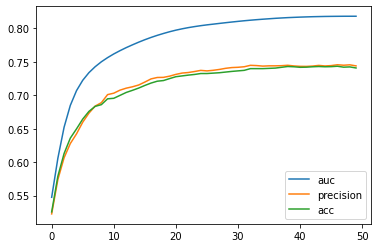

In [ ]:
validationMetrics = []
for i in range(50):
    rgcn.train()
    optimizer.zero_grad()
    # pred = rgcn(train.x_dict, train.edge_index_dict,
    #              train['Gene', "associates",'Disease'].edge_label_index)
    target = rgcn_train.edge_label
    label_edge_index = rgcn_train.edge_label_index
    rgcn_train.to(device)
    h = rgcn.encode(rgcn_train.x.long(),rgcn_train.edge_index.long(),rgcn_train.edge_type.long())
    loss  = rgcn.recon_loss(h,label_edge_index[:,target==1],label_edge_index[:,target==0])
    loss.backward()
    optimizer.step()

    rgcn.eval()
    auc, p ,acc= rgcn.test(h, rgcn_train.edge_label_index,rgcn_train.edge_label)
    # print(i, "train" ,np.array([auc, p , acc,loss.item()]).round(3),end=" ")

    with torch.no_grad():
        rgcn_test.to(device)
        z = rgcn.encode(rgcn_test.x.long(),rgcn_test.edge_index.long(),rgcn_test.edge_type.long())
        auc, p ,acc= rgcn.test(z, rgcn_test.edge_label_index,rgcn_test.edge_label)
        # auc, p = rgcn.test(z, valid.edge_label_index[:,valid.edge_label==1],valid.edge_label_index[:,valid.edge_label==0])
        validationMetrics.append([auc, p , acc])
        # print("valid",np.array([auc, p , acc]).round(3))

plt.plot(np.arange(len(validationMetrics)),np.array(validationMetrics)[:,0],label='auc')
plt.plot(np.arange(len(validationMetrics)),np.array(validationMetrics)[:,1],label='precision')
plt.plot(np.arange(len(validationMetrics)),np.array(validationMetrics)[:,2],label='acc')
plt.legend()
plt.show()